# Train LSTM on CGM Data

This notebook cell series demonstrates loading CGM data from `cgm/data/Clarity_Export_Harlow_Iain_2025-05-20_233242.csv`, preparing it into sliding windows, and comparing multiple recurrent architectures (LSTM vs GRU) and hyperparameter settings to predict the next glucose value.


In [1]:
%load_ext autoreload
%autoreload 2

In [15]:
# Top-level imports for CGM modeling notebook
import sys
import os

# Ensure we can import our script module
sys.path.append(os.path.abspath('..'))

from scripts.train_lstm_cgm import load_data, create_sequences

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import joblib

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam



## Initial architecture comparison

In this step, we train three simple configurations—  
- LSTM with 50 units  
- LSTM with 100 units  
- GRU  with 50 units  

This quick test reveals whether an LSTM or GRU (and roughly what size) performs best on our CGM prediction task.

In [2]:

# Configuration
DATA_FILE = '../data/Clarity_Export_Harlow_Iain_2025-05-20_233242.csv'
SEQ_LENGTH = 24
MODELS = [
    {'type': 'LSTM', 'units': 50},
    {'type': 'LSTM', 'units': 100},
    {'type': 'GRU',  'units': 50},
]

# Load and scale
df = load_data(DATA_FILE)
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df.values)
X, y = create_sequences(scaled, SEQ_LENGTH)
X = X.reshape((len(X), SEQ_LENGTH, 1))

# Train, evaluate, and collect results
results = []
for cfg in MODELS:
    model = Sequential()
    layer = LSTM if cfg['type']=='LSTM' else GRU
    model.add(layer(cfg['units'], activation='relu', input_shape=(SEQ_LENGTH,1)))
    model.add(Dense(1))
    model.compile(optimizer=Adam(1e-3), loss='mse')

    es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(
        X, y,
        epochs=30,
        batch_size=32,
        validation_split=0.2,
        callbacks=[es],
        verbose=0
    )
    best_val = min(history.history['val_loss'])
    results.append({'model': f"{cfg['type']}_{cfg['units']}", 'val_loss': best_val})

# Compare
import pandas as pd
results_df = pd.DataFrame(results).sort_values('val_loss').reset_index(drop=True)
results_df

/Users/iainharlow/projects/personal/cgm/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/iainharlow/projects/personal/cgm/.venv/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


,model,val_loss
0,GRU_50,0.001355
1,LSTM_100,0.001382
2,LSTM_50,0.001677


## Broad hyperparameter grid

Here we explore a wide range of models across:  
- Cell type (LSTM vs GRU)  
- Hidden units (50, 100, 150)  
- Layer count (1 vs 2)  
- Learning rate (1e-3 vs 1e-4)

This comprehensive sweep (24 runs) gives us a full performance landscape before we tighten our search.

In [3]:

# Define the grid
param_grid = {
    'cell_type': ['LSTM', 'GRU'],
    'units':    [50, 100, 150],
    'layers':   [1, 2],
    'lr':       [1e-3, 1e-4],
}
# Flatten into a list of dicts
configs = [
    dict(zip(param_grid, vals))
    for vals in product(*param_grid.values())
]

results = []
for cfg in configs:
    # Build model dynamically
    model = Sequential()
    RNN = LSTM if cfg['cell_type']=='LSTM' else GRU
    for i in range(cfg['layers']):
        # Return sequences if not last layer
        return_seq = (i < cfg['layers'] - 1)
        if i == 0:
            model.add(RNN(cfg['units'], activation='relu',
                          return_sequences=return_seq,
                          input_shape=(SEQ_LENGTH, 1)))
        else:
            model.add(RNN(cfg['units'], activation='relu',
                          return_sequences=return_seq))
    model.add(Dense(1))
    model.compile(
        optimizer=Adam(cfg['lr']),
        loss='mse'
    )

    # Train with early stopping to save time
    es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    history = model.fit(
        X, y,
        epochs=20,
        batch_size=32,
        validation_split=0.2,
        callbacks=[es],
        verbose=0
    )

    # Record best validation loss
    best_val = min(history.history['val_loss'])
    results.append({
        'model': f"{cfg['cell_type']}_{cfg['layers']}x{cfg['units']}_lr{cfg['lr']}",
        'val_loss': best_val
    })

# Summarize
pd.DataFrame(results).sort_values('val_loss').reset_index(drop=True)

/Users/iainharlow/projects/personal/cgm/.venv/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


,model,val_loss
0,GRU_2x100_lr0.001,0.001353
1,GRU_1x100_lr0.001,0.001364
2,GRU_1x150_lr0.001,0.001388
3,LSTM_2x150_lr0.001,0.001398
4,GRU_2x150_lr0.001,0.001472
5,LSTM_2x100_lr0.001,0.001537
6,GRU_2x50_lr0.001,0.001577
7,LSTM_1x150_lr0.001,0.001678
8,LSTM_1x50_lr0.001,0.001683
9,GRU_1x50_lr0.001,0.001765


## Focused GRU tuning

Based on earlier results, this grid zeroes in on GRUs around the 100-unit sweet spot. We vary:  
- Layers: 1 or 2  
- Units: 80, 100, or 120  
- Dropout: 0.0 or 0.1  
- Learning rate: 5×10⁻⁴  

A total of 12 targeted experiments will identify our final production model.

In [4]:

# fixed seq length and scaler setup as before…
SEQ_LENGTH = 24
LR = 5e-4   # a bit slower than 1e-3, but not as slow as 1e-4

# We’ll focus on GRUs only (they gave us the best results)
# and explore around the 100-unit sweet spot, plus light regularization.
param_grid = {
    'layers':  [1, 2],
    'units':   [80, 100, 120],
    'dropout': [0.0, 0.1],
}

configs = [dict(zip(param_grid, vals)) for vals in product(*param_grid.values())]

results = []
for cfg in configs:
    # build a GRU stack
    model = Sequential()
    for i in range(cfg['layers']):
        return_seq = (i < cfg['layers'] - 1)
        if i == 0:
            model.add(GRU(cfg['units'],
                          activation='relu',
                          return_sequences=return_seq,
                          input_shape=(SEQ_LENGTH, 1)))
        else:
            model.add(GRU(cfg['units'],
                          activation='relu',
                          return_sequences=return_seq))
        if cfg['dropout'] > 0:
            model.add(Dropout(cfg['dropout']))
    model.add(Dense(1))
    model.compile(optimizer=Adam(LR), loss='mse')

    # quick early‐stop run
    es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    history = model.fit(
        X, y,
        epochs=30,
        batch_size=32,
        validation_split=0.2,
        callbacks=[es],
        verbose=0
    )
    best_val = min(history.history['val_loss'])
    results.append({
        'config': f"GRU_{cfg['layers']}x{cfg['units']}_dr{cfg['dropout']}_lr{LR}",
        'val_loss': best_val
    })

pd.DataFrame(results).sort_values('val_loss')

/Users/iainharlow/projects/personal/cgm/.venv/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


,config,val_loss
8,GRU_2x100_dr0.0_lr0.0005,0.001388
7,GRU_2x80_dr0.1_lr0.0005,0.001417
9,GRU_2x100_dr0.1_lr0.0005,0.001509
11,GRU_2x120_dr0.1_lr0.0005,0.001518
10,GRU_2x120_dr0.0_lr0.0005,0.001523
6,GRU_2x80_dr0.0_lr0.0005,0.001618
4,GRU_1x120_dr0.0_lr0.0005,0.001652
2,GRU_1x100_dr0.0_lr0.0005,0.001653
1,GRU_1x80_dr0.1_lr0.0005,0.001838
5,GRU_1x120_dr0.1_lr0.0005,0.001959


## Window length sweep

Now that we’ve settled on a 2-layer GRU with 100 units, 0.0 dropout and LR=5×10⁻⁴, let’s find the optimal amount of history to feed in. We’ll compare sequence lengths of 6, 12, 24 and 48 readings (≈1.5 h, 3 h, 6 h and 12 h at 15 min intervals) by training each for up to 30 epochs with early stopping and recording validation MSE.

In [6]:


# Configuration
DATA_FILE = '../data/Clarity_Export_Harlow_Iain_2025-05-20_233242.csv'
LR = 5e-4
CFG = {'layers': 2, 'units': 100, 'dropout': 0.0}

# Load & scale full dataset once
df = load_data(DATA_FILE)
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df.values)

results = []
for seq_len in [6, 12, 24, 48]:
    X, y = create_sequences(scaled, seq_len)
    X = X.reshape((len(X), seq_len, 1))
    
    # Build model
    model = Sequential()
    for i in range(CFG['layers']):
        return_seq = (i < CFG['layers'] - 1)
        if i == 0:
            model.add(GRU(CFG['units'], activation='relu',
                          return_sequences=return_seq,
                          input_shape=(seq_len, 1)))
        else:
            model.add(GRU(CFG['units'], activation='relu',
                          return_sequences=return_seq))
        if CFG['dropout'] > 0:
            model.add(Dropout(CFG['dropout']))
    model.add(Dense(1))
    model.compile(optimizer=Adam(LR), loss='mse')
    
    # Train with early stopping
    es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    history = model.fit(
        X, y,
        epochs=30,
        batch_size=32,
        validation_split=0.2,
        callbacks=[es],
        verbose=0
    )
    
    results.append({
        'seq_length': seq_len,
        'val_loss': min(history.history['val_loss'])
    })

# Show comparative results
pd.DataFrame(results).sort_values('val_loss').reset_index(drop=True)

/Users/iainharlow/projects/personal/cgm/.venv/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


,seq_length,val_loss
0,24,0.001330
1,12,0.001354
2,48,0.001395
3,6,0.001539


## Final model training

Now that we’ve locked in our architecture (2-layer GRU, 100 units per layer, no dropout, LR=5×10⁻⁴, window=24), we train to full convergence. We’ll run for 100 epochs on an 80/20 split and then save the final model and scaler.

In [7]:
# Final model training cell

# Configuration
DATA_FILE   = '../data/Clarity_Export_Harlow_Iain_2025-05-20_233242.csv'
SEQ_LENGTH  = 24
LR          = 5e-4
LAYERS      = 2
UNITS       = 100
EPOCHS      = 100
BATCH_SIZE  = 32

# Load & prepare
df     = load_data(DATA_FILE)
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df.values)
X, y   = create_sequences(scaled, SEQ_LENGTH)
X      = X.reshape((len(X), SEQ_LENGTH, 1))

# Build the final GRU model
model = Sequential()
for i in range(LAYERS):
    return_seq = (i < LAYERS - 1)
    if i == 0:
        model.add(GRU(UNITS, activation='relu',
                      return_sequences=return_seq,
                      input_shape=(SEQ_LENGTH, 1)))
    else:
        model.add(GRU(UNITS, activation='relu',
                      return_sequences=return_seq))
model.add(Dense(1))
model.compile(optimizer=Adam(LR), loss='mse')

# Train to convergence
history = model.fit(
    X, y,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    verbose=1
)

# Save model & scaler
model.save('../models/final_gru_model.h5')
import joblib
joblib.dump(scaler, '../models/final_scaler.save')

Epoch 1/100


/Users/iainharlow/projects/personal/cgm/.venv/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0587 - val_loss: 0.0097
Epoch 2/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0062 - val_loss: 0.0053
Epoch 3/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0047 - val_loss: 0.0037
Epoch 4/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0041 - val_loss: 0.0026
Epoch 5/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0037 - val_loss: 0.0022
Epoch 6/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0035 - val_loss: 0.0028
Epoch 7/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0034 - val_loss: 0.0018
Epoch 8/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0029 - val_loss: 0.0026
Epoch 9/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0026 - val_loss: 0.0018
Epoch 10/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0027 - val_loss: 0.0017
Epoch 11/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0024 - val_loss: 0.0017
Epoch 12/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0

['../models/final_scaler.save']

## Surprise detection & sensor anomaly check

We’ll use our trained model to make one‐step‐ahead predictions and compute the absolute error (“surprise”) at each reading.  
1. **Top surprises:** List the readings with the largest errors.  
2. **Visualization:** Plot the full glucose series and overlay surprise on the same time axis.  
3. **Sensor anomalies:** Flag readings (or runs of readings) where surprise exceeds 20 mg/dL, indicating possible miscalibration or sensor faults.

,time,glucose,prediction,surprise
938,2025-05-17 08:17:22,133.0,97.720955,35.279045
444,2025-05-15 13:52:22,77.0,102.830322,25.830322
525,2025-05-15 20:47:22,105.0,79.683563,25.316437
59,2025-05-14 04:27:20,85.0,60.559383,24.440617
402,2025-05-15 10:17:22,142.0,117.827003,24.172997
1462,2025-05-19 05:07:25,117.0,93.709244,23.290756
1160,2025-05-18 03:32:23,99.0,121.110664,22.110664
195,2025-05-14 16:32:20,107.0,128.928864,21.928864
1831,2025-05-20 12:02:28,162.0,140.751022,21.248978
751,2025-05-16 15:57:21,121.0,100.269882,20.730118


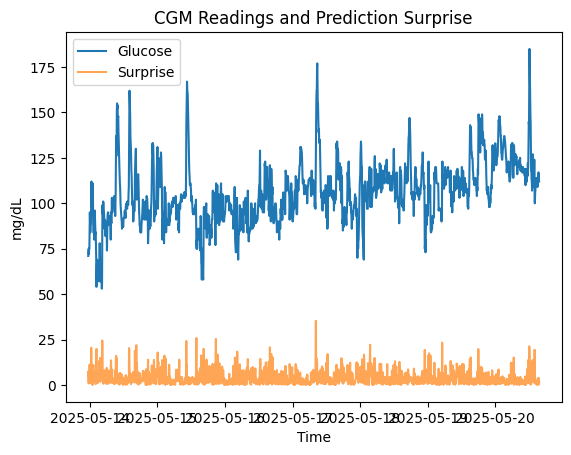

,time,glucose,prediction,surprise
12,2025-05-14 00:32:19,111.0,90.537506,20.462494
59,2025-05-14 04:27:20,85.0,60.559383,24.440617
171,2025-05-14 13:57:21,129.0,108.739288,20.260712
195,2025-05-14 16:32:20,107.0,128.928864,21.928864
402,2025-05-15 10:17:22,142.0,117.827003,24.172997
444,2025-05-15 13:52:22,77.0,102.830322,25.830322
525,2025-05-15 20:47:22,105.0,79.683563,25.316437
751,2025-05-16 15:57:21,121.0,100.269882,20.730118
938,2025-05-17 08:17:22,133.0,97.720955,35.279045
1160,2025-05-18 03:32:23,99.0,121.110664,22.110664


In [12]:
# Surprise/error computation and visualization

# 1. One‐step‐ahead predictions
preds, trues, times = [], [], []
for i in range(SEQ_LENGTH, len(scaled)):
    window = scaled[i-SEQ_LENGTH:i].reshape(1, SEQ_LENGTH, 1)
    p = model.predict(window, verbose=0)[0,0]
    preds.append(p)
    trues.append(scaled[i,0])
    times.append(df.index[i])

# 2. Un‐scale to mg/dL
preds_unscaled = scaler.inverse_transform(np.array(preds).reshape(-1,1)).flatten()
trues_unscaled = scaler.inverse_transform(np.array(trues).reshape(-1,1)).flatten()
errors = np.abs(trues_unscaled - preds_unscaled)

# 3. Compile into a DataFrame
surprise_df = pd.DataFrame({
    'time':  times,
    'glucose': trues_unscaled,
    'prediction': preds_unscaled,
    'surprise':  errors
})

# Top 10 most surprising readings
top10 = surprise_df.nlargest(10, 'surprise')
display(top10)

# 4. Visualization


plt.figure()
plt.plot(surprise_df['time'], surprise_df['glucose'], label='Glucose')
plt.plot(surprise_df['time'], surprise_df['surprise'], label='Surprise', alpha=0.7)
plt.xlabel('Time')
plt.ylabel('mg/dL')
plt.title('CGM Readings and Prediction Surprise')
plt.legend()
plt.show()

# 5. Flag potential sensor issues (surprise > 20 mg/dL)
anomalies = surprise_df[surprise_df['surprise'] > 20]
display(anomalies)

## Zoomed-in anomaly plots

Here we reload our final GRU model, scaler and full CGM series, compute one-step-ahead prediction errors (“surprise”), pick the top 4 anomalies, and for each plot a ±2 hour window showing both the true glucose trace and the surprise. Ensure your notebook is running the **cgm-venv** kernel (with TensorFlow installed) before pasting this cell.

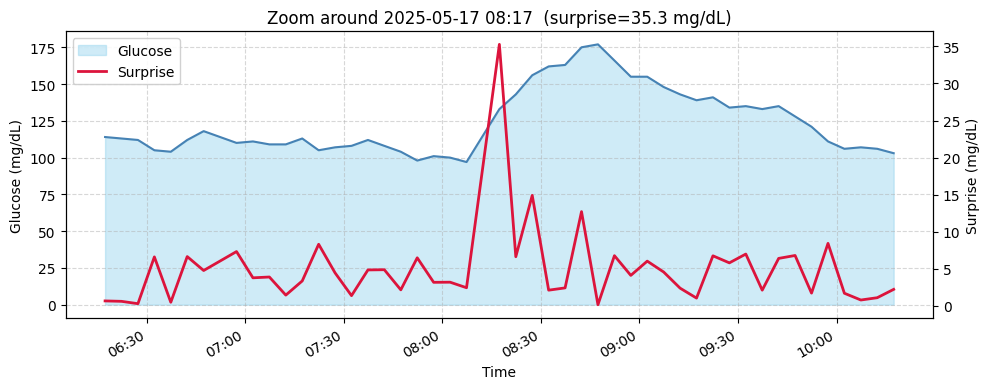

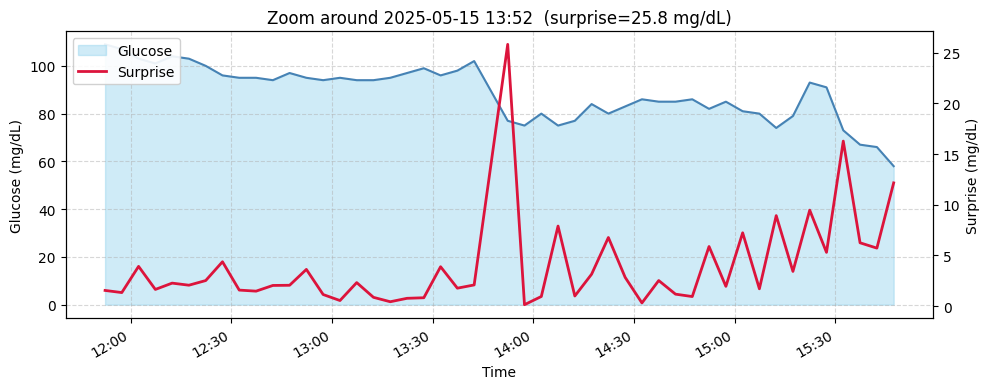

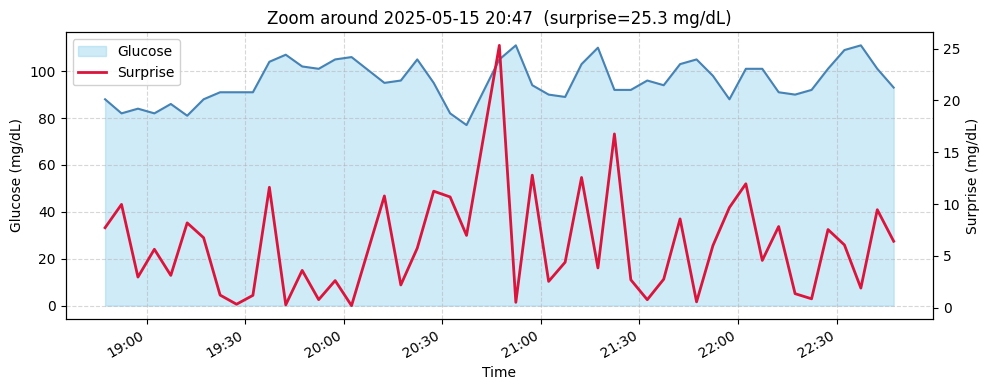

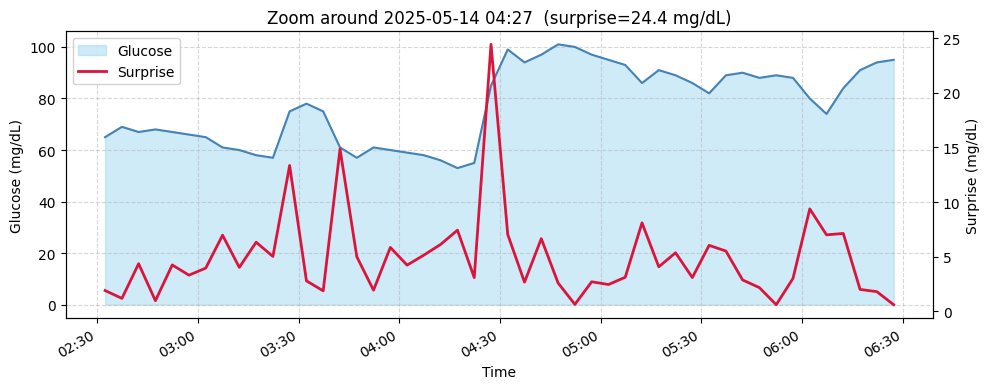

In [16]:
# Paths and settings
MODEL_PATH = '../models/final_gru_model.h5'
SCALER_PATH = '../models/final_scaler.save'
DATA_FILE  = '../data/Clarity_Export_Harlow_Iain_2025-05-20_233242.csv'
SEQ_LENGTH = 24

# Load model without legacy compile, then recompile
model = load_model(MODEL_PATH, compile=False)
model.compile(optimizer=Adam(5e-4), loss='mse')

# Reload scaler and data
scaler = joblib.load(SCALER_PATH)
df     = load_data(DATA_FILE)

# Prepare sequences
scaled      = scaler.transform(df.values)
X_all, y_all = create_sequences(scaled, SEQ_LENGTH)
X_all       = X_all.reshape((len(X_all), SEQ_LENGTH, 1))

# Predict and un-scale
preds       = model.predict(X_all, verbose=0).flatten()
trues       = y_all.flatten()
preds_un    = scaler.inverse_transform(preds.reshape(-1,1)).flatten()
trues_un    = scaler.inverse_transform(trues.reshape(-1,1)).flatten()
times       = df.index[SEQ_LENGTH:]
errors      = np.abs(trues_un - preds_un)

# Build surprise DataFrame & pick top 4 anomalies
surprise_df = pd.DataFrame({
    'glucose':    trues_un,
    'surprise':   errors
}, index=times)
anomalies   = surprise_df.nlargest(4, 'surprise')

# Plot ±2h window around each anomaly with area + line + twin axis
for t, row in anomalies.iterrows():
    window = surprise_df.loc[t - pd.Timedelta(hours=2) : t + pd.Timedelta(hours=2)]
    fig, ax = plt.subplots(figsize=(10, 4))

    # Glucose area + line
    ax.fill_between(window.index,
                    window['glucose'],
                    color='skyblue',
                    alpha=0.4,
                    label='Glucose')
    ax.plot(window.index,
            window['glucose'],
            color='steelblue')

    # Surprise line on secondary axis
    ax2 = ax.twinx()
    ax2.plot(window.index,
             window['surprise'],
             color='crimson',
             linewidth=2,
             label='Surprise')

    # Formatting
    ax.set_xlabel('Time')
    ax.set_ylabel('Glucose (mg/dL)')
    ax2.set_ylabel('Surprise (mg/dL)')
    ax.set_title(f"Zoom around {t.strftime('%Y-%m-%d %H:%M')}  "
                 f"(surprise={row['surprise']:.1f} mg/dL)")
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())

    # Combined legend
    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines1 + lines2, labels1 + labels2,
              loc='upper left', framealpha=0.9)

    fig.autofmt_xdate()
    plt.tight_layout()
    plt.show()